In [1]:
# Адаптируем размер тетрадки
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Описание проекта
<b> Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.<b/>
    
<b> Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. <b/>

## Описание тарифов
<b> Тариф «Смарт» <b/>
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
<b>Тариф «Ультра»<b/>
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

## Описание данных
<b>Таблица calls (информация о звонках):<b/>
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок
  
<b>Таблица internet (информация об интернет-сессиях):<b/>
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя
  
<b>Таблица messages (информация о сообщениях):<b/> 
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение
    
<b>Таблица tariffs (информация о тарифах):<b/>
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<b>Таблица users (информация о пользователях):<b/>
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана
    

## Примечание
<b>«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.<b/>
    
<b>Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.<b/>

## Импортируем библиотеки и данные

In [1]:
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st

In [3]:
try:
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_users = pd.read_csv('/datasets/users.csv')
    
except:
    df_calls = pd.read_csv('calls.csv')
    df_internet = pd.read_csv('internet.csv', index_col=0)
    df_messages = pd.read_csv('messages.csv')
    df_tariffs = pd.read_csv('tariffs.csv')
    df_users = pd.read_csv('users.csv')
    

<a id='important'></a>

# Изучение данных

In [4]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Вывод.
Нужно привести данные к нужным типам. 
Есть пропуски и нулевые значения. Они не вызваны ошибками и их исправлять не следует.

# Подготовка данных

In [9]:
# для начала исправим столбцы с датой:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

In [10]:
# добавим столбец со значением месяца чтобы посчитать расход по месяцам
df_calls['month'] = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month

## Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (нужно вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

### количество сделанных звонков и израсходованных минут разговора по месяцам;

In [11]:
# округлим звонки в большую сторону так как будет считаться за минуту
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [12]:
calls = (df_calls
    
    .pivot_table(index = ['month','user_id'], values = ['id','duration'], aggfunc= {'id':'count','duration':'sum'})
    .sort_values(by= 'month')
        )
# переименуем колонку id:
calls.rename(columns={'id':'calls_count'}, inplace= True)
calls.head()

duration  calls_count
month user_id                       
1     1005         95.0           15
      1337        121.0           13
      1340         25.0            5
      1372        114.0           19
      1373          0.0            2

### количество отправленных сообщений по месяцам;

In [13]:
df_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [14]:
messages = (df_messages
    
    .pivot_table(index = ['month','user_id'], values = 'id', aggfunc='count')
    .sort_values(by= 'month')
)
messages.rename(columns={'id':'messages_count'}, inplace= True)
messages.head()

messages_count
month user_id                
1     1005                  7
      1337                  7
      1372                 12
      1373                 28
      1375                 75

### объем израсходованного интернет-трафика по месяцам;

In [15]:
# добавим столбец с расходом в ГБ.
df_internet['gb_used'] = df_internet['mb_used'] / 1024

# округлим расход в большую сторону так как любой перерасход будет считаться за целый ГБ.
df_internet['gb_used'] = df_internet['gb_used'].apply(np.ceil)
df_internet.head()

,id,mb_used,session_date,user_id,month,gb_used
0,1000_0,112.95,2018-11-25,1000,11,1.0
1,1000_1,1052.81,2018-09-07,1000,9,2.0
2,1000_2,1197.26,2018-06-25,1000,6,2.0
3,1000_3,550.27,2018-08-22,1000,8,1.0
4,1000_4,302.56,2018-09-24,1000,9,1.0


In [16]:
internet = (df_internet
    
    .pivot_table(index = ['month','user_id'], values = 'gb_used', aggfunc='sum')
    .sort_values(by= 'month')
)
internet.head()

gb_used
month user_id         
1     1005         7.0
      1337        28.0
      1340         6.0
      1372        13.0
      1373        19.0

### помесячную выручку с каждого пользователя

<b>бесплатный лимит тариф «Смарт»:<b/>
* 500 минут разговора (далее минута разговора: 3 рубля), 
* 50 сообщений (далее сообщение: 3 рубля) 
* 15 Гб интернет-трафика (далее 1 Гб интернет-трафика: 200 рублей)

<b>бесплатный лимит тариф «Ультра»: <b/>
* 3000 минут разговора (далее минута разговора: 1 рубль), 
* 1000 сообщений (далее сообщение: 1 рубль)
* 30 Гб интернет-трафика (далее 1 Гб интернет-трафика: 150 рублей)

In [17]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [18]:
# для начала объединим выборки с тарифом
tariff = df_users[['user_id','tariff']]
user = (calls
        .merge(messages, on=['month','user_id'], how= 'outer')
        .merge(internet, on=['month','user_id'], how= 'outer')
        .merge(tariff, on='user_id', how= 'left')
       )
# вернем столбец month
user['month'] = df_calls['month']
# заменим пропуски на 0
user.loc[user['messages_count'].isna(),['messages_count']] = 0
user.loc[user['calls_count'].isna(),['calls_count']] = 0
user.loc[user['duration'].isna(),['duration']] = 0
user.loc[user['gb_used'].isna(),['gb_used']] = 0
user.head()

,user_id,duration,calls_count,messages_count,gb_used,tariff,month
0,1005,95.0,15.0,7.0,7.0,smart,7
1,1337,121.0,13.0,7.0,28.0,smart,8
2,1340,25.0,5.0,0.0,6.0,smart,6
3,1372,114.0,19.0,12.0,13.0,smart,9
4,1373,0.0,2.0,28.0,19.0,smart,12


In [19]:
df_tariffs['gb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024
df_tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [20]:
def monthly_revenue(row):
    """
    Функция по расчету ежемесячной выручки. Опции по тарифам соотносятся с информацией из таблицы df_tariffs.
    """
    total_cost = 0

    tariff = row['tariff']
    calls_sum = row['calls_count']
    messages_count = row['messages_count']
    gb_sum_internet = row['gb_used']

    # Считается разница между потраченными минутами, трафиком, смс и объемом услуг, включенных в абонентскую плату
    difference_calls = calls_sum - int(df_tariffs[df_tariffs['tariff_name'] == tariff]['minutes_included'])
    difference_messages = messages_count - int(df_tariffs[df_tariffs['tariff_name'] == tariff]['messages_included'])
    difference_internet = gb_sum_internet - int(df_tariffs[df_tariffs['tariff_name'] == tariff]['gb_per_month_included'])

    # Если пользователь вышел за пределы лимитов, обозначенных в абонентской плате, то рассчитывается дополнительная оплата
    if (difference_calls > 0):
        total_cost += difference_calls * int(df_tariffs[df_tariffs['tariff_name'] == tariff]['rub_per_minute'])
    if difference_messages > 0:
        total_cost += difference_messages * int(df_tariffs[df_tariffs['tariff_name'] == tariff]['rub_per_message'])
    if difference_internet > 0:
        total_cost += difference_internet * int(df_tariffs[df_tariffs['tariff_name'] == tariff]['rub_per_gb'])

    # Добавление ежемесячной абонентской платы
    total_cost += int(df_tariffs[df_tariffs['tariff_name'] == tariff]['rub_monthly_fee'])

    return total_cost    

In [21]:
user['total_cost']=user.apply(monthly_revenue, axis=1)
user.sort_values(by='user_id')
display(user.head())
user.describe()

,user_id,duration,calls_count,messages_count,gb_used,tariff,month,total_cost
0,1005,95.0,15.0,7.0,7.0,smart,7,550.0
1,1337,121.0,13.0,7.0,28.0,smart,8,3150.0
2,1340,25.0,5.0,0.0,6.0,smart,6,550.0
3,1372,114.0,19.0,12.0,13.0,smart,9,550.0
4,1373,0.0,2.0,28.0,19.0,smart,12,1350.0


,user_id,duration,calls_count,messages_count,gb_used,month,total_cost
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,451.244866,63.038892,38.281269,41.114499,8.372433,5424.170504
std,144.659172,241.909978,33.236368,36.148326,16.610698,2.806510,2848.102735
min,1000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,550.000000
25%,1125.000000,282.000000,40.000000,9.000000,31.000000,6.000000,3000.000000
50%,1253.000000,443.000000,62.000000,30.000000,42.000000,9.000000,5374.000000
75%,1378.750000,589.000000,82.000000,57.000000,52.000000,11.000000,7350.000000
max,1499.000000,1673.000000,244.000000,224.000000,101.000000,12.000000,17849.000000


<b>Посмотрим на общую выручку по тарифам:

In [22]:
display(user.query('tariff == "smart"')['total_cost'].describe())
user.query('tariff == "smart"')['total_cost'].sum()

count     2229.000000
mean      6122.267384
std       2834.554093
min        550.000000
25%       4368.000000
50%       6192.000000
75%       7950.000000
max      17849.000000
Name: total_cost, dtype: float64

13646534.0

In [23]:
display(user.query('tariff == "ultra"')['total_cost'].describe())
user.query('tariff == "ultra"')['total_cost'].sum()

count      985.000000
mean      3844.416244
std       2166.139153
min       1950.000000
25%       1950.000000
50%       3150.000000
75%       5250.000000
max      12150.000000
Name: total_cost, dtype: float64

3786750.0

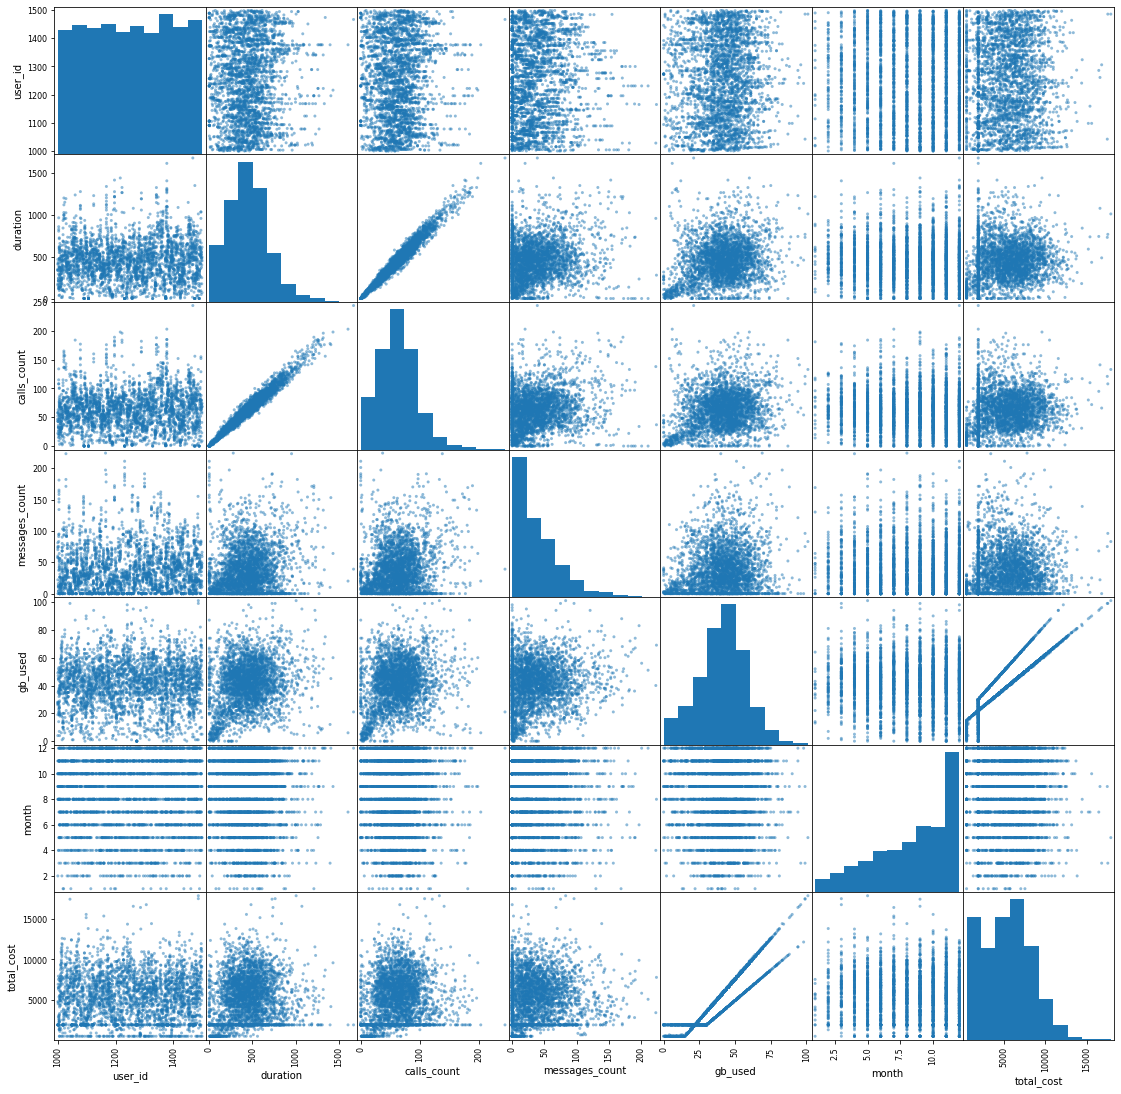

In [24]:
pd.plotting.scatter_matrix(user,figsize=(19, 19))
plt.show()

# Проанализируем данные

<b> Исходя из графика видно, что клиенты оператора тратят больше ближе к новому году. Выборка взята за год. Возможно связано с увеличением клиентской базы за этот период.

## Проведем дополнительный аналих

In [25]:
user.head()

,user_id,duration,calls_count,messages_count,gb_used,tariff,month,total_cost
0,1005,95.0,15.0,7.0,7.0,smart,7,550.0
1,1337,121.0,13.0,7.0,28.0,smart,8,3150.0
2,1340,25.0,5.0,0.0,6.0,smart,6,550.0
3,1372,114.0,19.0,12.0,13.0,smart,9,550.0
4,1373,0.0,2.0,28.0,19.0,smart,12,1350.0


###  Сколько минут разговора, требуется пользователям каждого тарифа в месяц

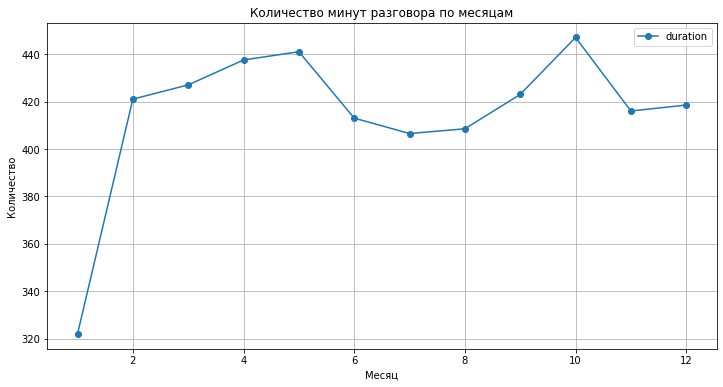

In [26]:
calls_smart = (user
               .query('tariff == "smart"')
               .pivot_table(index= ['month'], values= 'duration', aggfunc= 'median')
               .plot( style='o-', grid=True, figsize=(12, 6))
)
plt.title('Количество минут разговора по месяцам')
plt.ylabel('Количество')
plt.xlabel('Месяц')
plt.show()

Средняя продолжительность разговора для пользователя тарифа smart: 419.75
Средняя продолжительность разговора для пользователя тарифа ultra: 521.0


,Средняя продолжительность разговора для пользователя тарифа smart
month,
1,322.0
2,421.0
3,427.0
4,437.5
5,441.0
6,413.0
7,406.5
8,408.5
9,423.0


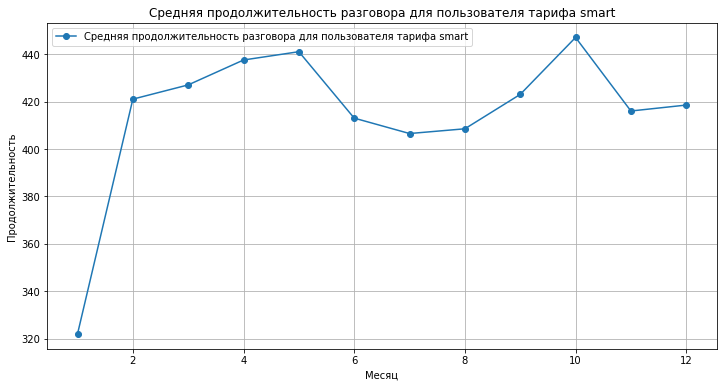

,Средняя продолжительность разговора для пользователя тарифа ultra
month,
1,713.0
2,559.5
3,616.0
4,600.0
5,501.0
6,542.0
7,479.0
8,488.0
9,503.0


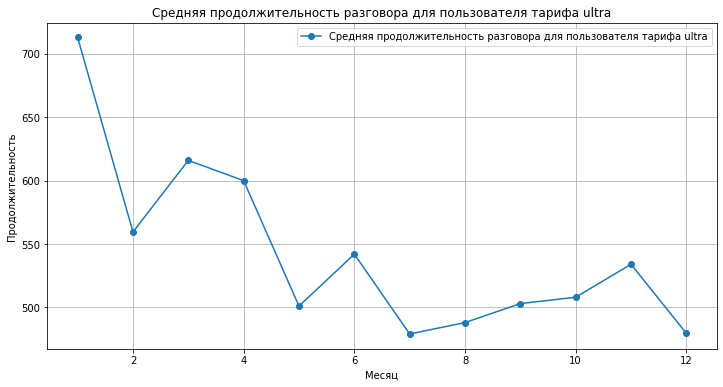

In [27]:
calls_smart = (user
               .query('tariff == "smart"')
               .pivot_table(index= ['month'], values= 'duration', aggfunc= 'median')
               )
calls_smart.rename(columns={'duration':'Средняя продолжительность разговора для пользователя тарифа smart'}, inplace= True)
print('Средняя продолжительность разговора для пользователя тарифа smart:', calls_smart['Средняя продолжительность разговора для пользователя тарифа smart'].median())

calls_ultra = (user
          .query('tariff == "ultra"')
          .pivot_table(index= ['month'], values= 'duration', aggfunc= 'median')
         )
calls_ultra.rename(columns={'duration':'Средняя продолжительность разговора для пользователя тарифа ultra'}, inplace= True)
print('Средняя продолжительность разговора для пользователя тарифа ultra:', calls_ultra['Средняя продолжительность разговора для пользователя тарифа ultra'].median())

display(calls_smart)
calls_smart.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Средняя продолжительность разговора для пользователя тарифа smart')
plt.ylabel('Продолжительность')
plt.xlabel('Месяц')
plt.show()

display(calls_ultra)
calls_ultra.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Средняя продолжительность разговора для пользователя тарифа ultra')
plt.ylabel('Продолжительность')
plt.xlabel('Месяц')
plt.show()

<b>  Вывод:  </b>
    
* Средняя продолжительность разговора для пользователя тарифа smart: 419.75
* Средняя продолжительность разговора для пользователя тарифа ultra: 521.0

Из графиков можно заметить, что пользователи чаще всего общаються дольше 400 минут. При этом пользователи тарифа 'ultra' общаются гораздо дольше пользователей тарифа 'smart'.

###   Cколько сообщений, требуется пользователям каждого тарифа в месяц

Среднее количество смс для пользователя тарифа smart 29.0
Среднее количество смс для пользователя тарифа ultra 40.25


,Среднее количество смс для пользователя тарифа smart
month,
1,32.0
2,36.0
3,30.0
4,29.0
5,32.0
6,22.0
7,31.0
8,26.0
9,28.0


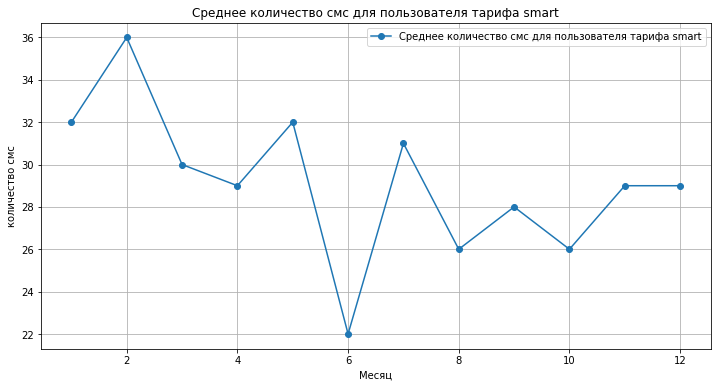

,Среднее количество смс для пользователя тарифа ultra
month,
1,60.5
2,43.0
3,40.5
4,56.0
5,35.0
6,36.0
7,42.0
8,42.5
9,28.5


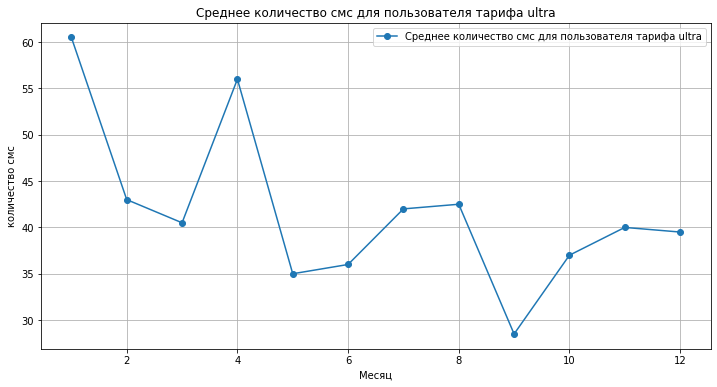

In [28]:
sms_smart = (user
          .query('tariff == "smart"')
          .pivot_table(index= ['month'], values= 'messages_count', aggfunc= 'median')
         )
sms_smart.rename(columns={'messages_count':'Среднее количество смс для пользователя тарифа smart'}, inplace= True)
print('Среднее количество смс для пользователя тарифа smart', sms_smart['Среднее количество смс для пользователя тарифа smart'].median())

sms_ultra = (user
          .query('tariff == "ultra"')
          .pivot_table(index= ['month'], values= 'messages_count', aggfunc= 'median')
         )
sms_ultra.rename(columns={'messages_count':'Среднее количество смс для пользователя тарифа ultra'}, inplace= True)
print('Среднее количество смс для пользователя тарифа ultra', sms_ultra['Среднее количество смс для пользователя тарифа ultra'].median())


display(sms_smart)
sms_smart.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Среднее количество смс для пользователя тарифа smart')
plt.ylabel('количество смс')
plt.xlabel('Месяц')
plt.show()

display(sms_ultra)
sms_ultra.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Среднее количество смс для пользователя тарифа ultra')
plt.ylabel('количество смс')
plt.xlabel('Месяц')
plt.show()

<b>  Вывод:  </b>
    
* Среднее количество смс для пользователя тарифа smart 29.0
* Среднее количество смс для пользователя тарифа ultra 40.25

Из графиков можно заметить, что пользователи чаще всего посылают больше 20 sms. При этом пользователи тарифа 'ultra' посылают гораздо больше пользователей тарифа 'smart'.

###  Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

Средний расход GB для пользователя тарифа smart: 43.0
Средний расход GB для пользователя тарифа ultra: 38.0


,Средний расход GB для пользователя тарифа smart
month,
1,38.0
2,41.0
3,47.0
4,45.0
5,44.5
6,43.0
7,44.0
8,43.0
9,42.0


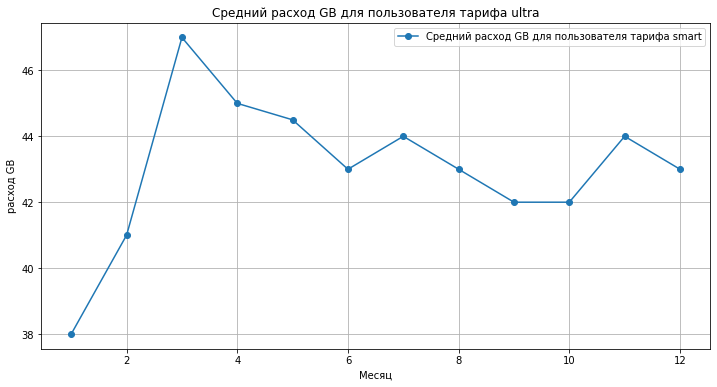

,Средний расход GB для пользователя тарифа ultra
month,
1,40.5
2,38.0
3,38.0
4,40.0
5,34.0
6,35.0
7,37.0
8,38.0
9,39.0


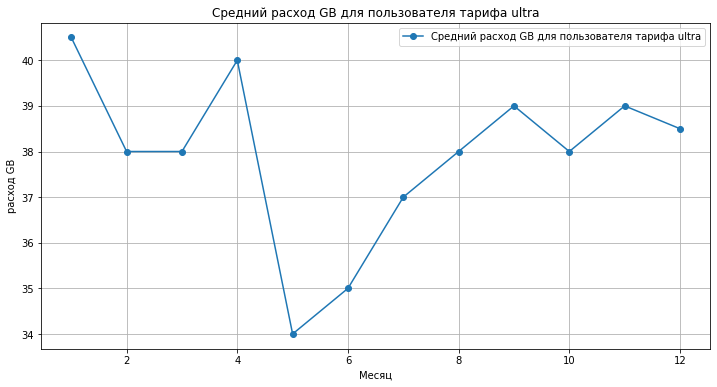

In [29]:
internet_smart = (user
          .query('tariff == "smart"')
          .pivot_table(index= ['month'], values= 'gb_used', aggfunc= 'median')
         )
internet_smart.rename(columns={'gb_used':'Средний расход GB для пользователя тарифа smart'}, inplace= True)
print('Средний расход GB для пользователя тарифа smart:', internet_smart['Средний расход GB для пользователя тарифа smart'].median())

internet_ultra = (user
          .query('tariff == "ultra"')
          .pivot_table(index= ['month'], values= 'gb_used', aggfunc= 'median')
         )
internet_ultra.rename(columns={'gb_used':'Средний расход GB для пользователя тарифа ultra'}, inplace= True)
print('Средний расход GB для пользователя тарифа ultra:', internet_ultra['Средний расход GB для пользователя тарифа ultra'].median())


display(internet_smart)
internet_smart.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Средний расход GB для пользователя тарифа ultra')
plt.ylabel('расход GB')
plt.xlabel('Месяц')
plt.show()

display(internet_ultra)
internet_ultra.plot( style='o-', grid=True, figsize=(12, 6))
plt.title('Средний расход GB для пользователя тарифа ultra')
plt.ylabel('расход GB')
plt.xlabel('Месяц')
plt.show()

<b>  Вывод:  </b>
    
* Средний расход GB для пользователя тарифа smart: 43.0
* Средний расход GB для пользователя тарифа ultra: 38.0

Из графиков можно заметить, что пользователи чаще всего используют больше 34 gb. При этом пользователи тарифа 'ultra' используют гораздо больше пользователей тарифа 'smart'.

###  Посчитаем  дисперсию и стандартное отклонение.

In [30]:
# Найдем дисперсию и стандартное отклонение для тарифа смарт:
variance_smart = user.query('tariff == "smart"')
variance_smart = np.var(variance_smart['total_cost'])
print('Дисперсия для тарифа смарт:', variance_smart)

standard_deviation_smart = user.query('tariff == "smart"')
standard_deviation_smart = np.std(standard_deviation_smart['total_cost'])
print('Стандартное отклонение для тарифа смарт:', standard_deviation_smart)

Дисперсия для тарифа смарт: 8031092.283821827
Стандартное отклонение для тарифа смарт: 2833.918185802446


In [31]:
# Найдем дисперсию и стандартное отклонение для тарифа ультра:
variance_ultra = user.query('tariff == "ultra"')
variance_ultra = np.var(variance_ultra['total_cost'])
print('Дисперсия для тарифа ultra:', variance_ultra)

standard_deviation_ultra = user.query('tariff == "ultra"')
standard_deviation_ultra = np.std(standard_deviation_ultra['total_cost'])
print('Стандартное отклонение для тарифа ultra:', standard_deviation_ultra)

Дисперсия для тарифа ultra: 4687395.217604164
Стандартное отклонение для тарифа ultra: 2165.039310868088


###  Построим гистограммы.

In [32]:
display(user.describe())
display(user.query('tariff == "smart"').describe())
user.query('tariff == "ultra"').describe()

,user_id,duration,calls_count,messages_count,gb_used,month,total_cost
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,451.244866,63.038892,38.281269,41.114499,8.372433,5424.170504
std,144.659172,241.909978,33.236368,36.148326,16.610698,2.806510,2848.102735
min,1000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,550.000000
25%,1125.000000,282.000000,40.000000,9.000000,31.000000,6.000000,3000.000000
50%,1253.000000,443.000000,62.000000,30.000000,42.000000,9.000000,5374.000000
75%,1378.750000,589.000000,82.000000,57.000000,52.000000,11.000000,7350.000000
max,1499.000000,1673.000000,244.000000,224.000000,101.000000,12.000000,17849.000000


,user_id,duration,calls_count,messages_count,gb_used,month,total_cost
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,417.934948,58.463437,33.384029,42.418125,8.312696,6122.267384
std,146.119496,190.313730,25.939858,28.227876,14.943104,2.799481,2834.554093
min,1001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,550.000000
25%,1121.000000,282.000000,40.000000,10.000000,34.000000,6.000000,4368.000000
50%,1239.000000,422.000000,60.000000,28.000000,43.000000,9.000000,6192.000000
75%,1376.000000,545.000000,76.000000,51.000000,52.000000,11.000000,7950.000000
max,1499.000000,1435.000000,198.000000,143.000000,101.000000,12.000000,17849.000000


,user_id,duration,calls_count,messages_count,gb_used,month,total_cost
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,526.623350,73.392893,49.363452,38.164467,8.507614,3844.416244
std,140.694908,317.606098,43.916853,47.804457,19.564656,2.819105,2166.139153
min,1000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1950.000000
25%,1143.000000,284.000000,41.000000,6.000000,23.000000,6.000000,1950.000000
50%,1277.000000,518.000000,74.000000,38.000000,38.000000,9.000000,3150.000000
75%,1381.000000,752.000000,104.000000,79.000000,52.000000,11.000000,5250.000000
max,1495.000000,1673.000000,244.000000,224.000000,98.000000,12.000000,12150.000000


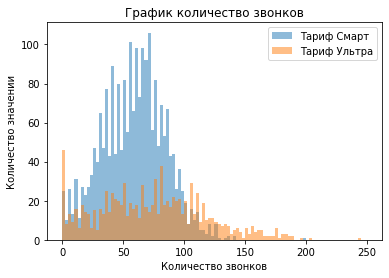

In [33]:
# График для количество звонков
plt.hist(user.query('tariff == "smart"')['calls_count'], label='Тариф Смарт', bins=100, alpha=0.5, range = (0, 250))
plt.hist(user.query('tariff == "ultra"')['calls_count'], label='Тариф Ультра', bins=100, alpha=0.5, range = (0, 250))
plt.legend()
plt.title('График количество звонков')
plt.ylabel('Количество значении')
plt.xlabel('Количество звонков')
plt.show()

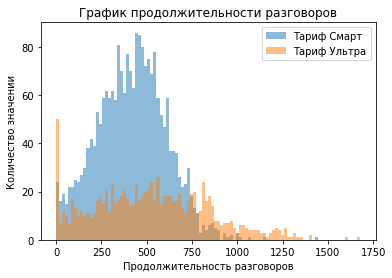

In [34]:
# График для продолжительности разговоров
plt.hist(user.query('tariff == "smart"')['duration'], label='Тариф Смарт', bins=100, alpha=0.5, range = (0, 1680))
plt.hist(user.query('tariff == "ultra"')['duration'], label='Тариф Ультра', bins=100, alpha=0.5, range = (0, 1680))
plt.legend()
plt.title('График продолжительности разговоров')
plt.ylabel('Количество значении')
plt.xlabel('Продолжительность разговоров')
plt.show()

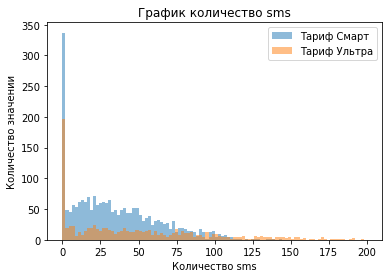

In [35]:
# График для количество sms
plt.hist(user.query('tariff == "smart"')['messages_count'], label='Тариф Смарт', bins=100, alpha=0.5, range = (0, 200))
plt.hist(user.query('tariff == "ultra"')['messages_count'], label='Тариф Ультра', bins=100, alpha=0.5, range = (0, 200))
plt.legend()
plt.title('График количество sms')
plt.ylabel('Количество значении')
plt.xlabel('Количество sms')
plt.show()

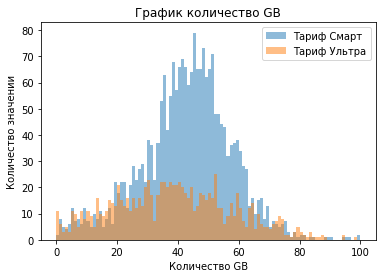

In [36]:
# График для количество GB
plt.hist(user.query('tariff == "smart"')['gb_used'], label='Тариф Смарт', bins=100, alpha=0.5, range = (0, 100))
plt.hist(user.query('tariff == "ultra"')['gb_used'], label='Тариф Ультра', bins=100, alpha=0.5, range = (0, 100))
plt.legend()
plt.title('График количество GB')
plt.ylabel('Количество значении')
plt.xlabel('Количество GB')
plt.show()

<b>
Можно сделать вывод, что большая часть клиентов совершают от 40 до 80 звонков с средней общей длительностью разговоров 290 до 600 минут. Болшая часть пользователей отправляют до 75 sms и используют от 30 до 60 гб. При этом количество наблюдении тарифа смарт значительно превышает тариф ультра. Значительная часть пользователей не используют sms сообщения вовсе.


# Проверим гипотезы

##  Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [37]:
user

,user_id,duration,calls_count,messages_count,gb_used,tariff,month,total_cost
0,1005,95.0,15.0,7.0,7.0,smart,7,550.0
1,1337,121.0,13.0,7.0,28.0,smart,8,3150.0
2,1340,25.0,5.0,0.0,6.0,smart,6,550.0
3,1372,114.0,19.0,12.0,13.0,smart,9,550.0
4,1373,0.0,2.0,28.0,19.0,smart,12,1350.0
...,...,...,...,...,...,...,...,...
3209,1473,0.0,0.0,20.0,32.0,ultra,12,2250.0
3210,1091,0.0,0.0,42.0,27.0,ultra,12,1950.0
3211,1106,0.0,0.0,24.0,40.0,ultra,8,3450.0
3212,1231,0.0,0.0,191.0,67.0,ultra,5,7500.0


H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

alpha = 1%

In [38]:
smart = user.query('tariff == "smart"')['total_cost']
ultra = user.query('tariff == "ultra"')['total_cost']

alpha = .01
results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2116782986957364e-104
Отвергаем нулевую гипотезу


##  Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 — средняя выручка пользователей из Москвы и из других регионов различаются.

alpha = 1%

In [39]:
#Для начала добавим столбец с городами
city = df_users[['city','user_id']]
user = user.merge(city, on = 'user_id' )
user

,user_id,duration,calls_count,messages_count,gb_used,tariff,month,total_cost,city
0,1005,95.0,15.0,7.0,7.0,smart,7,550.0,Набережные Челны
1,1005,456.0,69.0,38.0,22.0,smart,9,1950.0,Набережные Челны
2,1005,606.0,77.0,56.0,25.0,smart,11,2568.0,Набережные Челны
3,1005,712.0,101.0,41.0,24.0,smart,10,2350.0,Набережные Челны
4,1005,595.0,73.0,42.0,20.0,smart,11,1550.0,Набережные Челны
...,...,...,...,...,...,...,...,...,...
3209,1489,0.0,0.0,20.0,46.0,smart,11,6750.0,Санкт-Петербург
3210,1489,0.0,0.0,35.0,45.0,smart,5,6550.0,Санкт-Петербург
3211,1328,0.0,0.0,6.0,47.0,ultra,11,4500.0,Мурманск
3212,1328,0.0,0.0,8.0,74.0,ultra,9,8550.0,Мурманск


In [40]:
moscow_city = user.query('city == "Москва"')['total_cost']
other_city = user.query('city != "Москва"')['total_cost']

alpha = .01
results = st.ttest_ind(
    moscow_city, 
    other_city)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.3258095088189443
Не получилось отвергнуть нулевую гипотезу


<b> Пояснение:
    
Гипотезы формировал по принципу H0 - старая гипотеза, H1 - новая. Для проверки использовал специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам так как эти генеральные совокупности не зависят друг от друга и их средние нормально распределены.
    

# Общий вывод

<b>
Проанализировав все данные можно сделать вывод, что количество пользователей тарифа "smart" значительно больше тарифа "ultra". Общий чек пользователей тарифа "smart" (13 924 751р) значительно превышает общий чек пользователей тарифа "ultra" (3 786 750р).  Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Большая часть клиентов совершают от 40 до 90 звонков с средней длительностью разговоров 290 до 600 минут. Болшая часть пользователей отправляют до 75 sms и используют от 30 до 50 гб. Значительная часть пользователей не используют sms сообщения вовсе. 
    
* Средняя продолжительность разговора для пользователя тарифа smart: 420 минут
* Средняя продолжительность разговора для пользователя тарифа ultra: 521 минут
* Среднее количество смс для пользователя тарифа smart в месяц: 29
* Среднее количество смс для пользователя тарифа ultra в месяц: 40
* Средний расход GB для пользователя тарифа smart в месяц: 43
* Средний расход GB для пользователя тарифа ultra в месяц: 38



<b>
Из всего выше сказанного можно сделать вывод, что коммерческому департаменту компании «Мегалайна», следует скорректировать рекламный бюджет в пользу тарифного плана: «Смарт»